In [8]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import fnmatch
import re

In [2]:
df_Xerunlist = pd.read_csv('./XeArapucaRunList.csv', sep = ';')
df_Xerunlist.head()

,Run Number,Config,Day/time,Comments,Efield
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False
2,10874,CRT_noprescale_delay_Feb00003,06/02/2020,"Biases for channels 0,6 and 8 to 11 of SSP 504...",False
3,10875,CRT_noprescale_delay_Feb00003,06/02/2020,Biases for channels 0 to 7 of SSP 504 brought ...,False
4,10877,XeDope_CRT_noprescale_delay_Feb00002,06/02/2020,New config with lower disc thresholds (70 ADC ...,False


In [4]:
## add time infos
df_Xetimelist = pd.read_csv('./timeinfos.txt', sep = '\t', header=None, names={'Run Number', 'daytime'})
df_Xetimelist['daytime'] = pd.to_datetime(df_Xetimelist['daytime'])
df_Xetimelist = df_Xetimelist.sort_values(by=['Run Number'] ).drop_duplicates(ignore_index = True)
df_Xetimelist.head()

,Run Number,daytime
0,10872,2020-02-06 13:51:48+00:00
1,10873,2020-02-06 14:03:28+00:00
2,10874,2020-02-06 14:25:00+00:00
3,10875,2020-02-06 15:38:58+00:00
4,10877,2020-02-06 16:06:42+00:00


In [5]:
df_tmp = pd.merge(df_Xerunlist, df_Xetimelist, how = 'inner', on=['Run Number'])

df_Xerunlist_info = df_tmp[['Run Number', 'Day/time', 'daytime', 'Efield']]
df_Xerunlist_info['Day/time'] = pd.to_datetime(df_Xerunlist_info['Day/time'], format='%d/%m/%Y')
df_Xerunlist_info['Day/time'] = df_Xerunlist_info['Day/time'].dt.strftime('%d %b')
df_Xerunlist_info.head()



,Run Number,Day/time,daytime,Efield
0,10872,06 Feb,2020-02-06 13:51:48+00:00,False
1,10873,06 Feb,2020-02-06 14:03:28+00:00,False
2,10874,06 Feb,2020-02-06 14:25:00+00:00,False
3,10875,06 Feb,2020-02-06 15:38:58+00:00,False
4,10877,06 Feb,2020-02-06 16:06:42+00:00,False


# Read my files and do the analysis


In [9]:
# read APA 3 files 

base_path_mod304 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304/Integral'
file_path_mod304 = os.path.join(base_path_mod304,'CalibratedIntegral_*.csv')

file_name_list_mod304 =  glob.glob(file_path_mod304) 
print('APA 3: Getting infos from ', len(file_name_list_mod304), 'runs ')


# read APA 6 files 

base_path_mod603 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603/Integral'
file_path_mod603 = os.path.join(base_path_mod603,'CalibratedIntegral_*.csv')

file_name_list_mod603 =  glob.glob(file_path_mod603) 
print('APA 6: Getting infos from ', len(file_name_list_mod603), 'runs ')


APA 3: Getting infos from  97 runs 
APA 6: Getting infos from  76 runs 


In [10]:
def readfile_list(filename_list):       
    
    def read_single_file(f):
        data = pd.read_csv(f, index_col=0)
        return data
    
    data_list = [read_single_file(f) for f in filename_list]
    return pd.concat(data_list, axis=0)
    

In [11]:
df_304 = readfile_list(file_name_list_mod304)
df_603 = readfile_list(file_name_list_mod603)


display(df_304.head())

display(df_603.head())


,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,7554.093236,475.629607,164.225912,1.000000,10620
1,11021,1,5965.158716,473.798684,163.436650,0.996151,10694
2,11021,2,6811.382174,478.290037,163.970221,1.005593,10659
3,11021,3,5707.479941,491.526595,165.134200,1.033423,10700
4,11021,4,13929.721287,477.829584,163.054736,1.004625,4830


,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,5534.322105,438.797034,144.886754,1.000000,6804
1,11021,1,14117.131841,450.359705,152.530278,1.026351,2504
2,11021,2,13022.030469,448.850498,143.627997,1.022911,2385
3,11021,3,15045.207965,415.431604,156.352321,0.946751,2247
4,11021,4,7202.065870,444.835992,145.092221,1.013763,6747


In [12]:
#create df apa3 for the integral

df_integral_304 = df_304.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_304.groupby(['Run number'])['n good evts'].sum())
df_integral_304['stat err'] = stat.values
df_integral_304.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_304.head()

,Run Number,Integral,stat err
0,10877,143112.006752,167.263266
1,10878,134258.434941,177.208916
2,10879,146913.710598,163.000000
3,10885,138948.518489,142.635900
4,10903,142025.626576,163.187009


In [13]:
df_apa3 = pd.merge(df_Xerunlist_info, df_integral_304, how = 'inner', on=['Run Number'])
df_apa3.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [14]:
#create df apa6 for the integral

df_integral_603 = df_603.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_603.groupby(['Run number'])['n good evts'].sum())
df_integral_603['stat err'] = stat.values
df_integral_603.rename(columns={'Run number': 'Run Number'}, inplace=True)

df_apa6 = pd.merge(df_Xerunlist_info, df_integral_603, how = 'inner', on=['Run Number'])
df_apa6.head()


,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10906,09 Feb,2020-02-09 09:38:25+00:00,False,117264.588563,80.901174
1,10907,09 Feb,2020-02-09 13:08:44+00:00,False,136793.434553,125.582642
2,10909,09 Feb,2020-02-09 20:41:41+00:00,False,127661.812705,76.111760
3,10915,10 Feb,2020-02-10 08:53:11+00:00,False,167335.857995,54.304696
4,10922,10 Feb,2020-02-10 15:40:03+00:00,False,140715.673310,38.223030


In [15]:
df_apa6['daytime'] = pd.to_datetime(df_apa6['daytime'], format='%d/%m/%Y')
df_apa6['daytime'] = df_apa6['daytime'].dt.strftime('%d %b : %I %p')
df_apa6.head()

df_apa3['daytime'] = pd.to_datetime(df_apa3['daytime'], format='%d/%m/%Y')
df_apa3['daytime'] = df_apa3['daytime'].dt.strftime('%d %b : %I %p')
df_apa3.head()


,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,06 Feb : 04 PM,False,143112.006752,167.263266
1,10878,06 Feb,06 Feb : 05 PM,False,134258.434941,177.208916
2,10879,06 Feb,06 Feb : 06 PM,False,146913.710598,163.000000
3,10885,07 Feb,07 Feb : 10 AM,False,138948.518489,142.635900
4,10903,08 Feb,08 Feb : 09 AM,False,142025.626576,163.187009


In [16]:
#define doping periods and corresponding df 
df_apa3_pre = df_apa3.loc[(df_apa3['Run Number'] < 10943)] 
df_apa3_dop_1 = df_apa3.loc[(df_apa3['Run Number'] >= 10943) & (df_apa3['Run Number'] < 10961) ] 
df_apa3_dop_2 = df_apa3.loc[(df_apa3['Run Number'] >= 11008) & (df_apa3['Run Number'] < 11102) ]
df_apa3_dop_3 = df_apa3.loc[(df_apa3['Run Number'] >= 11102) & (df_apa3['Run Number'] < 11144) ]
df_apa3_dop_4 = df_apa3.loc[(df_apa3['Run Number'] >= 11145) & (df_apa3['Run Number'] < 11245) ]


#define doping periods and corresponding df 
df_apa6_pre = df_apa6.loc[(df_apa6['Run Number'] < 10943)] 
df_apa6_dop_1 = df_apa6.loc[(df_apa6['Run Number'] >= 10943) & (df_apa6['Run Number'] < 10961) ] 
df_apa6_dop_2 = df_apa6.loc[(df_apa6['Run Number'] >= 11008) & (df_apa6['Run Number'] < 11102) ]
df_apa6_dop_3 = df_apa6.loc[(df_apa6['Run Number'] >= 11102) & (df_apa6['Run Number'] < 11144) ]
df_apa6_dop_4 = df_apa6.loc[(df_apa6['Run Number'] >= 11145) & (df_apa6['Run Number'] < 11245) ]






In [17]:
df_apa3_dop_2

,Run Number,Day/time,daytime,Efield,Integral,stat err
29,11013,27 Feb,27 Feb : 04 PM,False,108863.479248,301.176028
30,11014,28 Feb,28 Feb : 05 AM,False,125450.046447,328.233149
31,11015,28 Feb,28 Feb : 02 PM,False,145058.638590,312.529999
32,11016,29 Feb,28 Feb : 10 PM,False,154175.057335,278.591098
33,11017,29 Feb,29 Feb : 10 AM,False,118375.598498,320.926783
34,11018,01 Mar,29 Feb : 10 PM,False,165577.679557,265.904118
35,11021,02 Mar,01 Mar : 10 PM,False,130891.243951,311.462678
36,11092,16 Mar,16 Mar : 12 PM,False,139865.222488,283.959504
37,11101,02 Apr,02 Apr : 01 PM,False,168039.111719,281.480017


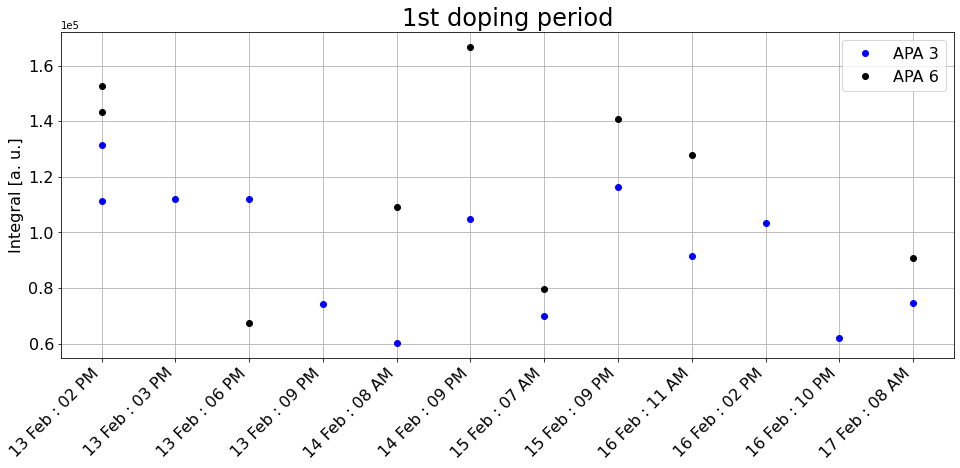

In [18]:
############################################################
#                           DOPING 1  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('1st doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_1['daytime'], y=df_apa3_dop_1['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_1['daytime'], y=df_apa6_dop_1['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()


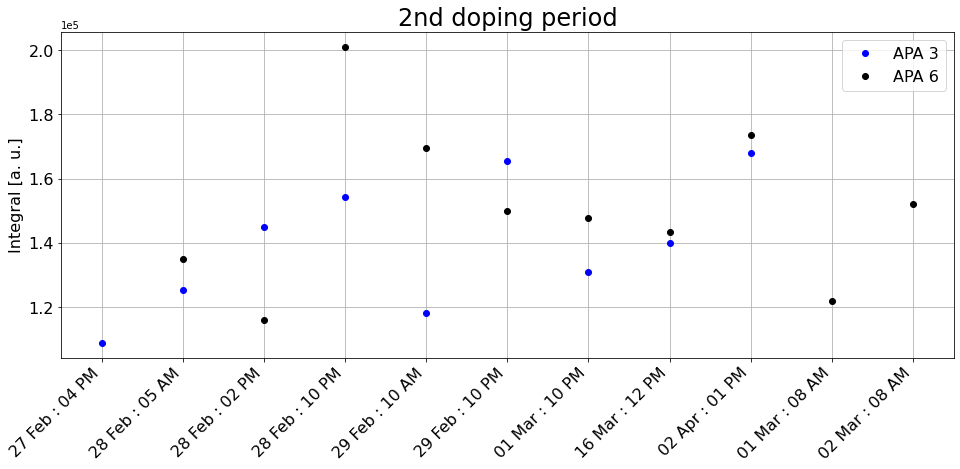

In [19]:
############################################################
#                           DOPING 2  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('2nd doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_2['daytime'], y=df_apa3_dop_2['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_2['daytime'], y=df_apa6_dop_2['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()


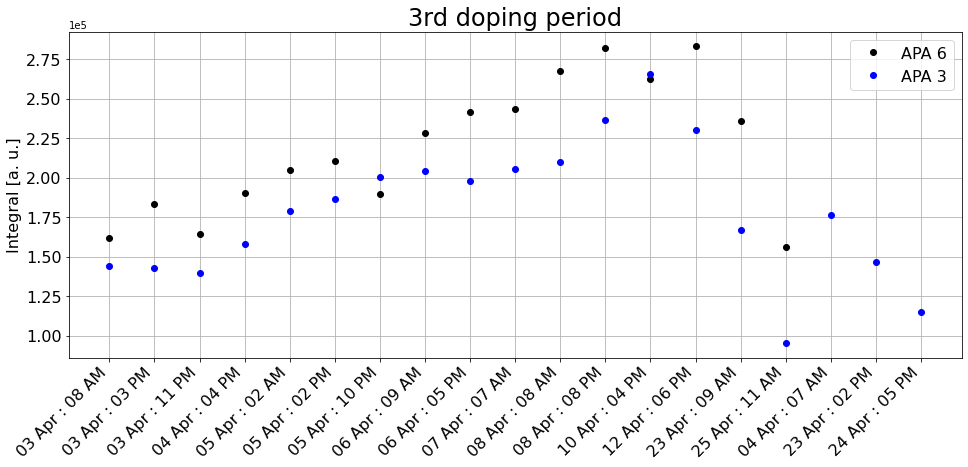

In [20]:
############################################################
#                           DOPING 3  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('3rd doping period', fontsize=24)
plt.errorbar(x=df_apa6_dop_3['daytime'], y=df_apa6_dop_3['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')
plt.errorbar(x=df_apa3_dop_3['daytime'], y=df_apa3_dop_3['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()



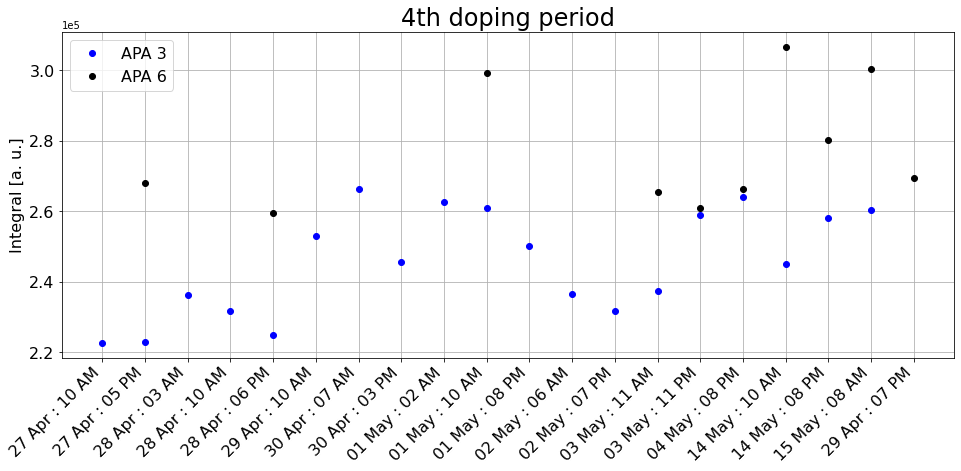

In [23]:
############################################################
#                           DOPING 4  
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('4th doping period', fontsize=24)
plt.errorbar(x=df_apa3_dop_4['daytime'], y=df_apa3_dop_4['Integral'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 3')
plt.errorbar(x=df_apa6_dop_4['daytime'], y=df_apa6_dop_4['Integral'], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label = 'APA 6')


plt.ylabel('Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
